In [1]:
# MA384 Final Project
# Example Data Sandbox
# Kevin Cotellesso

# Let's play with some data!
# This script includes a bunch of cells containing code snippets
# to do useful stuff with our S.M.A.R.T. data.

import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('example_data/example_Q3_2025/2025-07-01_reduced.csv')
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213459 entries, 0 to 213458
Columns: 197 entries, date to smart_255_raw
dtypes: bool(1), float64(187), int64(5), object(4)
memory usage: 319.4+ MB


Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num',
       ...
       'smart_250_normalized', 'smart_250_raw', 'smart_251_normalized',
       'smart_251_raw', 'smart_252_normalized', 'smart_252_raw',
       'smart_254_normalized', 'smart_254_raw', 'smart_255_normalized',
       'smart_255_raw'],
      dtype='object', length=197)

In [2]:
# Remove non-raw columns from the data.
# Drops columns that end in "_normalized"
df = df.drop([col for col in df.columns if col.endswith('_raw')], axis=1)
df.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'datacenter', 'cluster_id', 'vault_id', 'pod_id', 'pod_slot_num',
       ...
       'smart_244_normalized', 'smart_245_normalized', 'smart_246_normalized',
       'smart_247_normalized', 'smart_248_normalized', 'smart_250_normalized',
       'smart_251_normalized', 'smart_252_normalized', 'smart_254_normalized',
       'smart_255_normalized'],
      dtype='object', length=104)

In [3]:
# Make the column names into ints for smart attributes
# (but only the column names that include ints)

columns_as_ints = []
for column in df.columns:
    if '_' in column: # e.g., 'smart_5_normalized' or 'serial_number'
        parts = column.split('_')
        if parts[1].isdigit(): # e.g., 'smart_5_normalized'
            columns_as_ints.append(int(parts[1]))
        else: # e.g., 'serial_number'
            columns_as_ints.append(column)
    else: # e.g., 'date', 'model'
        columns_as_ints.append(column)

df.columns = columns_as_ints
df.columns

Index([          'date',  'serial_number',          'model', 'capacity_bytes',
              'failure',     'datacenter',     'cluster_id',       'vault_id',
               'pod_id',   'pod_slot_num',
       ...
                    244,              245,              246,              247,
                    248,              250,              251,              252,
                    254,              255],
      dtype='object', length=104)

In [4]:
# Replace int column names with attribute names from the SMART attributes mapping.
# Recommended to do this last; it's probably better to work with IDs as ints when merging datasets.
df_smart_attributes = pd.read_csv('SMART_attributes.csv')
df_smart_attributes.head(10)

# Create a mapping from ID to Name
id_to_name = dict(zip(df_smart_attributes['ID'], df_smart_attributes['Attribute name']))
df_renamed = df.rename(columns=id_to_name)
df_renamed.columns

Index([                                                 'date',
                                               'serial_number',
                                                       'model',
                                              'capacity_bytes',
                                                     'failure',
                                                  'datacenter',
                                                  'cluster_id',
                                                    'vault_id',
                                                      'pod_id',
                                                'pod_slot_num',
       ...
       'Total LBAs Read Expanded or Total Host Reads Expanded',
                             'Remaining Rated Write Endurance',
                             'Cumulative host sectors written',
                                     'Host program page count',
                               'Background program page count',
                             

There are 70 unique models in the dataset.


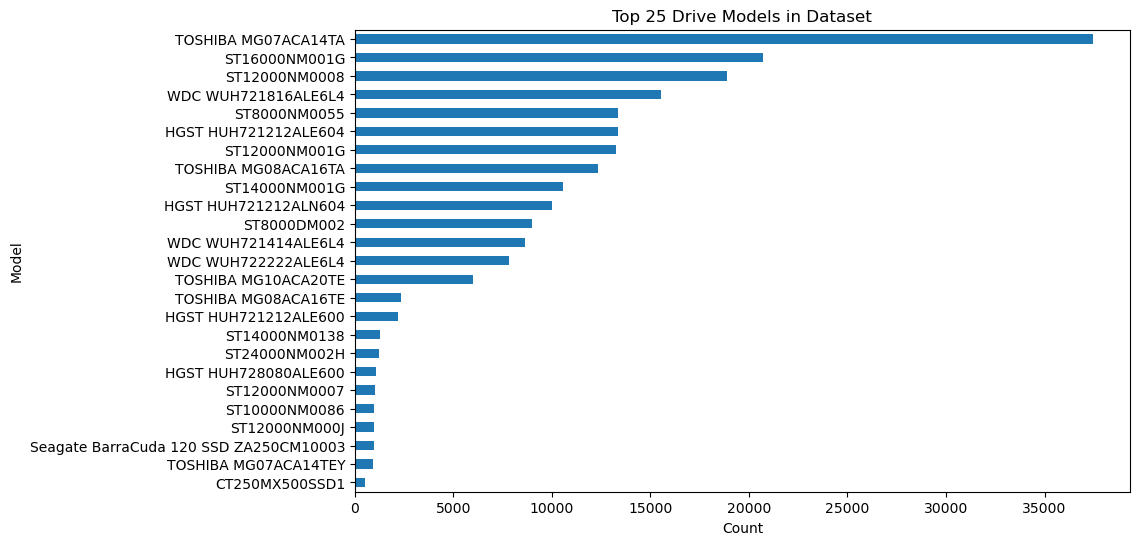

In [5]:
# What kind of models do we have in this dataset?
print(f"There are {len(df['model'].unique())} unique models in the dataset.")
# horizontal barchart of all models
plt.figure(figsize=(10,6))
df['model'].value_counts().head(25).sort_values().plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Model')
plt.title('Top 25 Drive Models in Dataset')
plt.show()

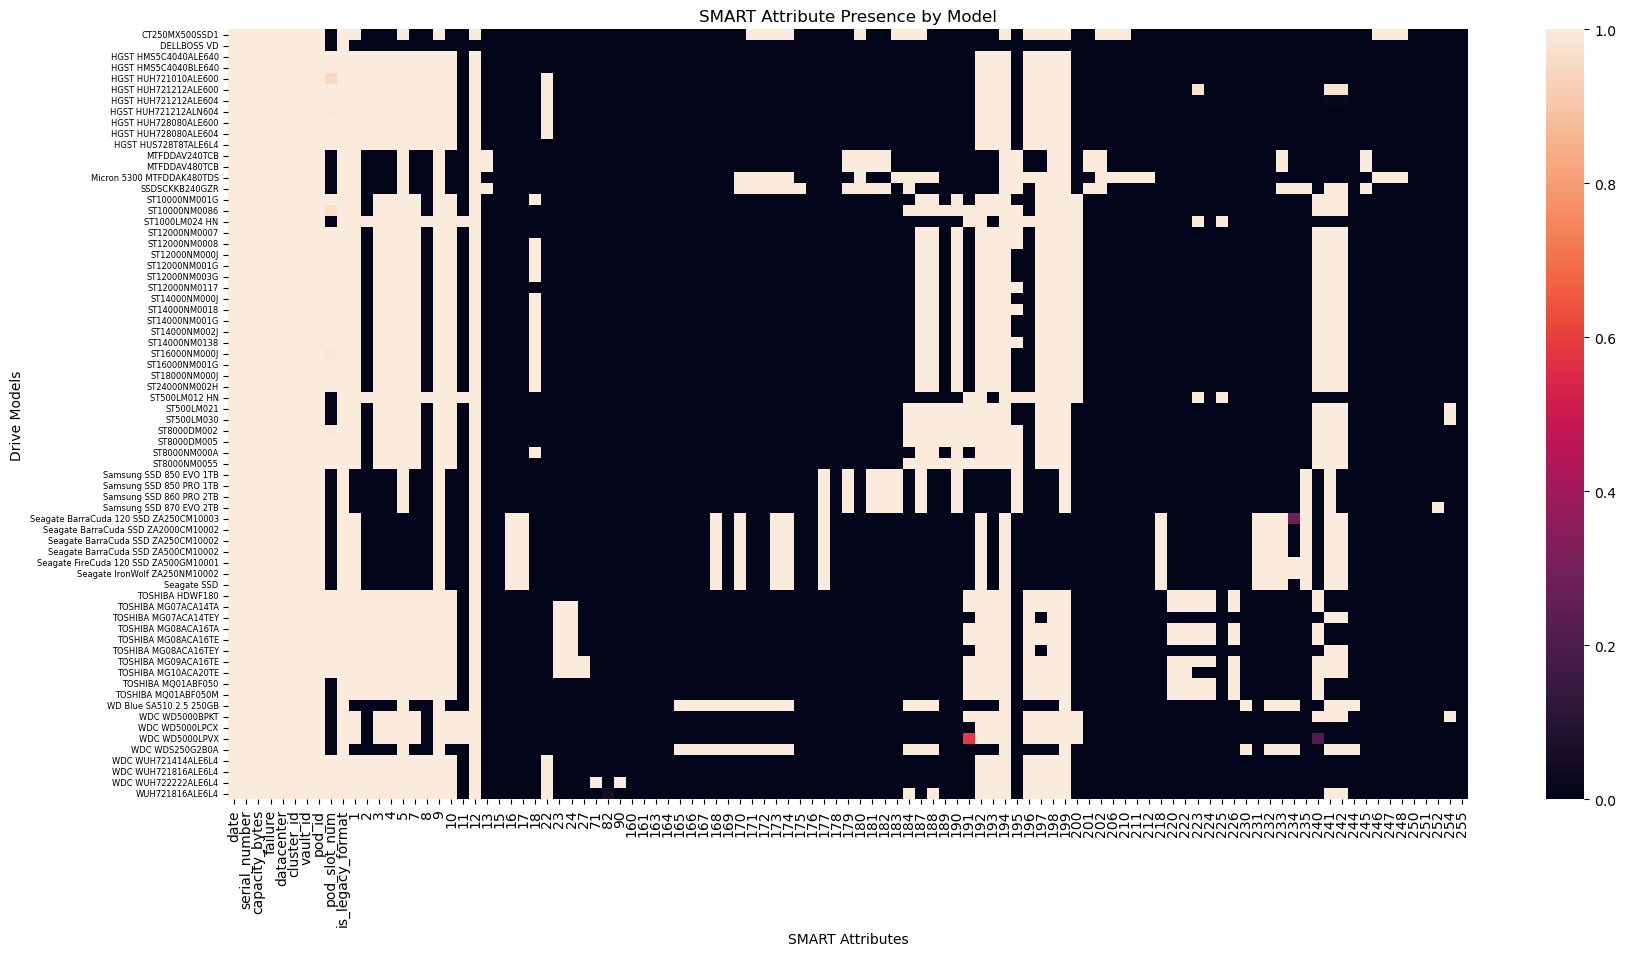

In [6]:
# Many smart attributes are only present on certain models.
# Make a heatmap showing which attributes are present on which models (on what percent of drives)
# A score of 1.0 means that attribute is present on all drives of that model.
import seaborn as sns
import matplotlib.pyplot as plt
df_model_attributes = df.groupby('model').agg(lambda x: x.notnull().mean())
plt.figure(figsize=(20,10))
sns.heatmap(df_model_attributes, cbar=True, yticklabels=True, xticklabels=True)
plt.yticks(rotation=0, fontsize=6)
plt.title('SMART Attribute Presence by Model')
plt.xlabel('SMART Attributes')
plt.ylabel('Drive Models')
plt.show()

In [7]:
# Example for how to sample a dataset such that it has equal numbers of failed and non-failed drives
df_failed = df[df['failure'] == 1]
df_non_failed = df[df['failure'] == 0].sample(n=len(df_failed), random_state=42)
df_balanced = pd.concat([df_failed, df_non_failed])
df_balanced

# NOTE! We probably want to do this AFTER paring down the dataset to only the drives/models we care about!

,date,serial_number,model,capacity_bytes,failure,datacenter,cluster_id,vault_id,pod_id,pod_slot_num,...,244,245,246,247,248,250,251,252,254,255
23582,2025-07-01,5PHHURZD,HGST HUH721212ALE604,12000138625024,1,phx1,0,1058,13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33109,2025-07-01,88P0A00GF97G,TOSHIBA MG07ACA14TA,14000519643136,1,phx1,0,1066,17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38268,2025-07-01,ZHZ65Y0A,ST12000NM0008,12000138625024,1,phx1,0,1070,12,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92913,2025-07-01,7030A05DF97G,TOSHIBA MG07ACA14TA,14000519643136,1,sac0,0,1116,7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116495,2025-07-01,ZL2GRJ9X,ST12000NM001G,12000138625024,1,sac2,0,1135,3,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113154,2025-07-01,88S0A03EF97G,TOSHIBA MG07ACA14TA,14000519643136,0,sac2,0,1133,11,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114891,2025-07-01,ZHZ50QNT,ST12000NM0008,12000138625024,0,sac0,0,1134,14,36.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81539,2025-07-01,ZL0052MZ,ST12000NM0008,12000138625024,0,sac2,0,1107,3,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36758,2025-07-01,10K0A0APF97G,TOSHIBA MG07ACA14TA,14000519643136,0,phx1,0,1069,7,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74432,2025-07-01,ZL005E4X,ST12000NM0008,12000138625024,0,sac0,0,1101,2,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
